Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [3]:
%%capture
import sys

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'



In [5]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [7]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [9]:
#Train validate split
train, val = train_test_split(train, train_size = 0.80, test_size = 0.20,
                              stratify = train['status_group'], random_state=3)

In [11]:
testog = test.copy()

In [13]:
import numpy as np


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

KeyError: "['quantity_group' 'payment_type'] not found in axis"

In [16]:
target = 'status_group'
# Re-arrange data into X features matrix and y target vector, so
# we use *all* features, including the high-cardinality categoricals
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test


In [18]:

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=3, n_jobs=-1,min_samples_split=12,n_estimators=400, max_depth=20)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Training Accuracy 0.9010942760942761
Validation Accuracy 0.8042929292929293


# New code

In [20]:
#pipeline y's

encoder = ce.OrdinalEncoder()
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(max_iter=1000)

y_train_encoded = encoder.fit_transform(y_train)


y_val_encoded = encoder.transform(y_val)


In [22]:
from sklearn.model_selection import cross_val_score

k = 3
scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [0.34027778 0.34556503 0.34769571]


In [24]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#from sklearn.model_selection import validation_curve
#from sklearn.tree import DecisionTreeRegressor

#pipeline3 = make_pipeline(
#    ce.OrdinalEncoder(), 
#    SimpleImputer(), 
#    RandomForestClassifier(n_jobs=-1)
#)

#depth = range(200, 500, 50)
#train_scores, val_scores = validation_curve(
#    pipeline3, X_train, y_train_encoded,
#    param_name='randomforestclassifier__n_estimators', 
#    param_range=depth, scoring="accuracy", 
##    cv=3,
#    n_jobs=-1
#)

#plt.figure(dpi=150)
#plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
#plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
#plt.ylim((0.2, 0.25)) 
#plt.title('Validation Curve')
#plt.xlabel('model complexity: DecisionTreeRegressor')
#plt.ylabel('model score: Mean Absolute Error')
#plt.legend();

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

In [27]:
""" pipeline2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=3, n_jobs=-1)
)
param_distributions = {    
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline2,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train_encoded) """

" pipeline2 = make_pipeline(\n    ce.OrdinalEncoder(),\n    SimpleImputer(),\n    RandomForestClassifier(random_state=3, n_jobs=-1)\n)\nparam_distributions = {    \n    'randomforestclassifier__n_estimators': randint(50, 500), \n    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], \n    'randomforestclassifier__max_features': uniform(0, 1), \n}\n\nsearch = RandomizedSearchCV(\n    pipeline2,\n    param_distributions=param_distributions,\n    n_iter=10,\n    cv=3,\n    scoring='neg_mean_absolute_error',\n    verbose=10,\n    return_train_score=True,\n    n_jobs=-1\n)\n\nsearch.fit(X_train, y_train_encoded) "

In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

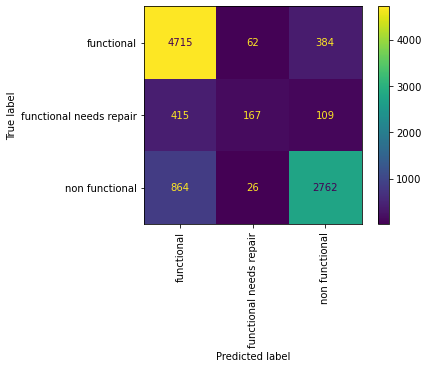

In [31]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [30]:

y_pred = pipeline.predict(X_test)


# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index


submission = testog[['id']].copy()
submission['status_group'] = y_pred
submission.to_csv('kagglesubmissionwaterpump.csv', index=False)





KeyError: "None of [Index(['id'], dtype='object')] are in the [columns]"